In [1]:
import torch
import numpy
import torch.nn as nn
import random
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio 
import io

In [2]:
#0, position, min = -1.2, max = 0.6
#1, velocity, min = -0.07, max = 0.07

In [3]:
#state = position, velocity
def get_mountain_car_data(force=0.001,gravity=0.0025):
    #no actions
    data = []
    position_linspace = np.arange(-1.2, 0.6, 0.01)
    velocity_linspace = np.arange(-0.07, 0.07, 0.01)
    for position in position_linspace:
        for velocity in velocity_linspace:
            state = torch.tensor([position, velocity],dtype=torch.float32)
            #nv = v + .001*(actions - 1) - .0025*np.cos(3*x) #changed action to 0
            next_velocity =  velocity + force*(0-1) - gravity*np.cos(3*position)
            next_position = position + next_velocity
            next_state = torch.tensor([next_position, next_velocity],dtype=torch.float32)
            data.append((state, next_state))
    return data

In [4]:
class LQR(nn.Module):
    def __init__(self, enc_dim,in_dim):
        super(LQR, self).__init__()
        self.A = torch.nn.Parameter(torch.randn(enc_dim, enc_dim))
       
        self.state_encoder = torch.nn.Sequential(
            torch.nn.Linear(in_dim, enc_dim//2),
            torch.nn.ReLU(),
            torch.nn.Linear(enc_dim//2, enc_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(enc_dim, enc_dim),
        )

        self.state_decoder = torch.nn.Sequential(
            torch.nn.Linear(enc_dim, enc_dim//2),
            torch.nn.ReLU(),
            torch.nn.Linear(enc_dim//2, in_dim)
        )
    def forward (self,x):
        xx = self.state_encoder(x)
        #xx = xx.squeeze(0)
        x_prime_prediction = self.A @ xx 
        return self.state_decoder(x_prime_prediction), x_prime_prediction, xx, #reward.unsqueeze(0)

In [5]:
def train_model(model,optimizer,train_data_loader,test_data,epochs=1):
    criterion = torch.nn.MSELoss()
    for i in range(epochs):
        total_state_loss = 0
        for x, y in train_data_loader:
            x = x.squeeze(0)
            y = y.squeeze(0)
            optimizer.zero_grad()
            lqr_x_prime, x_prime_expanded, xx = model(x)
            lqr_pred_loss = criterion(lqr_x_prime, y)
            decoder_loss = criterion(model.state_decoder(xx), x)
            encoder_loss = criterion(model.state_encoder(y), x_prime_expanded) 
            state_loss = lqr_pred_loss  + decoder_loss + encoder_loss
            loss = state_loss #+ reward_loss
            loss.backward()
            optimizer.step()
            total_state_loss += state_loss.item()
        test_state_loss = 0 
        for x,y in test_data:
            with torch.no_grad():
                x = x.squeeze(0)
                y = y.squeeze(0)
                lqr_x_prime, x_prime_expanded, xx = model(x)
                lqr_pred_loss = criterion(lqr_x_prime, y)
                decoder_loss = criterion(model.state_decoder(xx), x)
                encoder_loss = criterion(model.state_encoder(y), x_prime_expanded) 
                state_loss = lqr_pred_loss  + decoder_loss + encoder_loss
                test_state_loss += state_loss.item()
        print(f"Epoch {i} Training Loss: {total_state_loss/len(train_data_loader)} Test Loss: {test_state_loss/len(test_data)}")


In [6]:
all_data = get_mountain_car_data()
random.shuffle(all_data)

train_data = all_data[:int(len(all_data)*0.8)]
test_data = all_data[int(len(all_data)*0.8):]
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True)
print(f"Train Data Length: {len(train_data)}")
print(f"Test Data Length: {len(test_data)}")


Train Data Length: 2160
Test Data Length: 540


In [7]:
model = LQR(16,2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
train_model(model,optimizer,train_data_loader,test_data,epochs=50)

Epoch 0 Training Loss: 0.0743945263482517 Test Loss: 0.0020742298253228204
Epoch 1 Training Loss: 0.002386806887372788 Test Loss: 0.0017039900105306448
Epoch 2 Training Loss: 0.0016938511219218863 Test Loss: 0.0014391725892454377
Epoch 3 Training Loss: 0.0009001914606943518 Test Loss: 0.0002939481596681785
Epoch 4 Training Loss: 0.0002934592083105014 Test Loss: 5.798308424644987e-05
Epoch 5 Training Loss: 0.00015710788340896897 Test Loss: 8.609586983886351e-06
Epoch 6 Training Loss: 0.00025440022974798637 Test Loss: 1.1600331959542658e-05
Epoch 7 Training Loss: 0.00016395943545156075 Test Loss: 0.00021813355233967337
Epoch 8 Training Loss: 0.0001544595290856368 Test Loss: 0.00016140874280170937
Epoch 9 Training Loss: 0.00018608238961373362 Test Loss: 3.264447839481161e-05
Epoch 10 Training Loss: 0.0001815527057569447 Test Loss: 1.7185857367015463e-05
Epoch 11 Training Loss: 0.0001681938735364794 Test Loss: 7.664713526807005e-06
Epoch 12 Training Loss: 0.00014003024287121576 Test Loss: 

KeyboardInterrupt: 

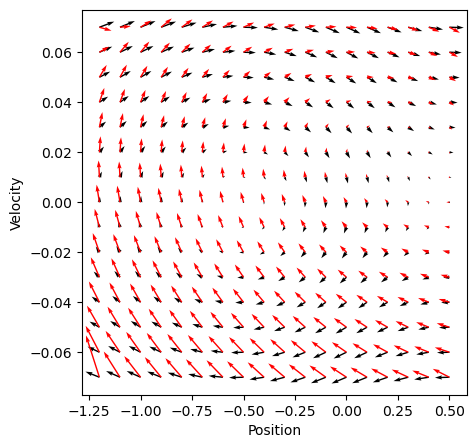

In [59]:
def plot_policy(model,ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    positions = np.arange(-1.2, 0.6, .1)
    velocities = np.arange(-0.07, 0.07, .01)

    X, V = np.meshgrid(positions, velocities)
    NX = np.zeros_like(X) + np.nan
    NV = np.zeros_like(V) + np.nan

    NX_model = np.zeros_like(X) + np.nan
    NV_model = np.zeros_like(V) + np.nan

    for i, x in enumerate(positions):
        flag = False
        for j, v in enumerate(velocities):
            actions = 0
            nv = v + .001*(0) - .0025*np.cos(3*x) #changed action to 0
            nx = x + nv

            next,_,_ = model(torch.tensor([x, v],dtype=torch.float32)) #new addition
            next = next.detach().numpy()
            #check if norm((nx, nv) - next) is small
            if np.linalg.norm(np.array([nx, nv]) - next) < 0.001:
                flag = True
                continue

        
            nx_model, nv_model = next
            NX_model[j, i] = np.round(nx_model, 5)#nx_model
            NV_model[j, i] = np.round(nv_model, 5)#nv_model
            NX[j, i] = np.round(nx, 5)#nx
            NV[j, i] = np.round(nv, 5)#nv
        if flag:
            continue
    DX = NX - X
    DV = NV - V
    DX_model = NX_model - X
    DV_model = NV_model - V
    # print("DX")
    # print(DX)
    # print("DV")
    # print(DV)
    # print("DV_model")
    # print(DV_model)
    # print("DX_model")
    # print(DX_model)

    

    q = ax.quiver(X, V, DX, DV, scale_units='xy', angles='xy', scale=1)
    q_model = ax.quiver(X, V, DX_model, DV_model, color='red',scale_units='xy', angles='xy', scale=1)

    # total_dx_max = np.max([DX.max(), DX_model.max()])
    # total_dx_min = np.min([DX.min(), DX_model.min()])
    # total_dy_max = np.max([DV.max(), DV_model.max()])
    # total_dy_min = np.min([DV.min(), DV_model.min()])
    # q = ax.quiver(X, V, DX/(total_dx_max - total_dx_min), DV/(total_dy_max - total_dy_min), scale_units='xy', scale=1)
    # q_model = ax.quiver(X, V, DX_model/(total_dx_max - total_dx_min), DV_model/(total_dy_max - total_dy_min), color='red',scale_units='xy', scale=1)
    ax.set_box_aspect(1)
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    # #increase plot x y lim
    # ax.set_xlim(-1.2,.6)
    # ax.set_ylim(-.07, .07)

plot_policy(model)

[[1.        0.9999984]
 [0.9999984 1.       ]]


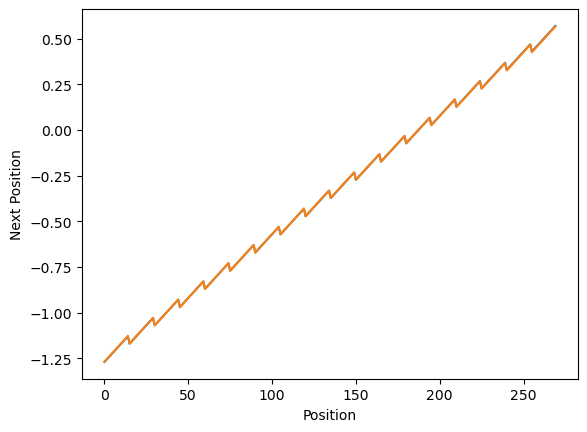

[[1.         0.99979963]
 [0.99979963 1.        ]]


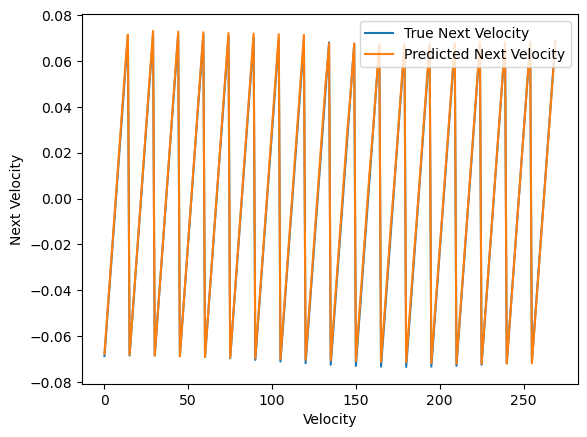

In [13]:
#plot true position compared to model position prediction

def plot_position(model,ax=None):
    true_positions = np.arange(-1.2, 0.6, .1)
    velocities = np.arange(-0.07, 0.07, .01)
    true_next_positions = []
    true_next_velocities = []
    for i in true_positions:
        for j in velocities: 
            nv = j + .001*(0 - 1) - .0025*np.cos(3*i)
            nx = i + nv
            true_next_positions.append(nx)
            true_next_velocities.append(nv)
   # print(len(true_next_positions))
    pred_next_positions = []
    pred_next_velocities = []
    for i in true_positions:
        for j in velocities:
            next,_,_ = model(torch.tensor([i, j],dtype=torch.float32))
            nx, nv = next
            pred_next_positions.append(nx.item())
            pred_next_velocities.append(nv.item())

    #print(len(pred_next_positions[0]))
    plt.plot(true_next_positions, label='True Next Position')
    plt.plot(pred_next_positions, label='Predicted Next Position')
    #get correlation
    print(np.corrcoef(true_next_positions,pred_next_positions))
    plt.xlabel('Position')
    plt.ylabel('Next Position')
    plt.show()

    plt.plot(true_next_velocities, label='True Next Velocity')
    plt.plot(pred_next_velocities, label='Predicted Next Velocity')
    print(np.corrcoef(true_next_velocities,pred_next_velocities))
    plt.xlabel('Velocity')
    plt.ylabel('Next Velocity')
    plt.legend()
    plt.show()

plot_position(model)